In [1]:
import torch
from torch import nn, optim, cuda
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import os
import csv
import random
from scipy.io import loadmat
import scipy.io as sio
import kagglehub
from sklearn.model_selection import train_test_split

**Verilerin Yüklenmesi**

In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import GTSRB
from torch.utils.data import DataLoader

# Veri Dönüşümlerini Tanımlama (Örneğin Normalize etme)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Görüntü boyutunu ayarlayın
    transforms.ToTensor(),  # Tensor'e dönüştürme
])

# Eğitim veri setini yükleme
train_dataset = GTSRB(root='data', split='train', download=True, transform=transform)

# Test veri setini yükleme
test_dataset = GTSRB(root='data', split='test', download=True, transform=transform)

# DataLoader ile veri yükleme
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 187M/187M [00:08<00:00, 21.0MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 89.0M/89.0M [00:04<00:00, 19.1MB/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 210kB/s]


Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


**Eksik Değer Kontrolü**

In [3]:
# Eğitim veri kümesinde eksik verileri kontrol etme
missing_train_data = [(i, image, label) for i in range(len(train_dataset)) if train_dataset[i][0] is None or train_dataset[i][1] is None]

# Test veri kümesinde eksik verileri kontrol etme
missing_test_data = [(i, image, label) for i in range(len(test_dataset)) if test_dataset[i][0] is None or test_dataset[i][1] is None]

# Eksik verilerin sayısını yazdırma
print(f"Number of missing data in training set: {len(missing_train_data)}")
print(f"Number of missing data in test set: {len(missing_test_data)}")

Number of missing data in training set: 0
Number of missing data in test set: 0


# **Resimlerin Okunması ve Kontrolü**

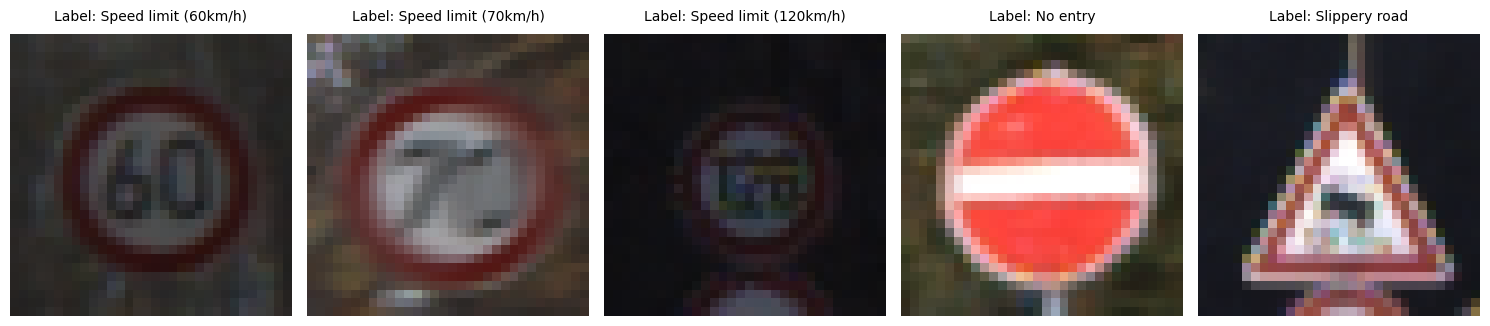

In [4]:
# Sınıf isimlerini yükleme
class_names = pd.read_csv('/content/drive/MyDrive/Yapay Sinir Ağları/Classes.csv')

# Veri Dönüşümlerini Tanımlama (Örneğin Normalize etme)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Görüntü boyutunu ayarlayın
    transforms.ToTensor(),  # Tensor'e dönüştürme
])


# DataLoader ile veri yükleme
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Örnek görüntüleri görselleştirerek veri yüklemesini kontrol etme
dataiter = iter(train_loader)
images, labels = next(dataiter)

# İlk birkaç görüntüyü görselleştirme
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax = axes[i]
    ax.imshow(images[i].permute(1, 2, 0))  # Tensör boyutlarını (C, H, W) -> (H, W, C) olarak değiştir
    # Etiketin anlamlı ismini almak için 'ClassId' ile 'SignName' ilişkilendirme
    class_id = labels[i].item()
    label_name = class_names[class_names['ClassId'] == class_id]['SignName'].values[0]
    ax.set_title(f"Label: {label_name}", fontsize=10, pad=10)  # Başlık font boyutunu küçültme ve başlık ile görüntü arasında boşluk ekleme
    ax.axis('off')

plt.tight_layout()  # Alt alanların düzgün yerleşmesini sağlamak için
plt.show()

**Train ve Test ayrımı**

In [5]:
def prepare_data(loader):
    images, labels = [], []
    for image, label in loader:
        # Verileri numpy array'e çevirip boyutları düzleştiriyoruz
        images.append(image.numpy().reshape(image.shape[0], -1))  # Görüntüleri düzleştiriyoruz
        labels.append(label.numpy())

    # Listeyi numpy array'e dönüştürüp birleştiriyoruz
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

    return images, labels

# Eğitim ve test veri setlerini ayırma
train_images, train_labels = prepare_data(train_loader)
test_images, test_labels = prepare_data(test_loader)

# %80 eğitim ve %20 test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [6]:
# Eğitim ve test setlerinin boyutları
print("Eğitim verisi boyutu (X_train):", X_train.shape)  # (num_samples_train, num_features)
print("Test verisi boyutu (X_test):", X_test.shape)  # (num_samples_test, num_features)
print("Eğitim etiketleri boyutu (y_train):", y_train.shape)  # (num_samples_train,)
print("Test etiketleri boyutu (y_test):", y_test.shape)  # (num_samples_test,)


Eğitim verisi boyutu (X_train): (21312, 3072)
Test verisi boyutu (X_test): (5328, 3072)
Eğitim etiketleri boyutu (y_train): (21312,)
Test etiketleri boyutu (y_test): (5328,)


#**MLP ile Model Oluşturma**

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Görüntüleri düzleştirme
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# StandardScaler'ı başlatma
scaler = StandardScaler()

# Eğitim verisini standartlaştırma
X_train_scaled = scaler.fit_transform(X_train_flattened)

# Test verisini standartlaştırma (Eğitim verisine göre dönüştürülmeli)
X_test_scaled = scaler.transform(X_test_flattened)

# MLP modelini oluşturma
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # 2 katmanlı, 128 ve 64 nöron
    activation='relu',  # ReLU aktivasyon fonksiyonu
    learning_rate_init=0.001,  # Öğrenme oranı
    max_iter=500,  # Maksimum iterasyon sayısı
    random_state=42
)

# Modeli eğitim verileriyle eğitme
mlp_model.fit(X_train_scaled, y_train)

# Test verisi ile doğruluğu hesaplama
y_pred = mlp_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Doğruluğu: {accuracy:.4f}")


Test Doğruluğu: 0.9608


**Confusion Matrix**

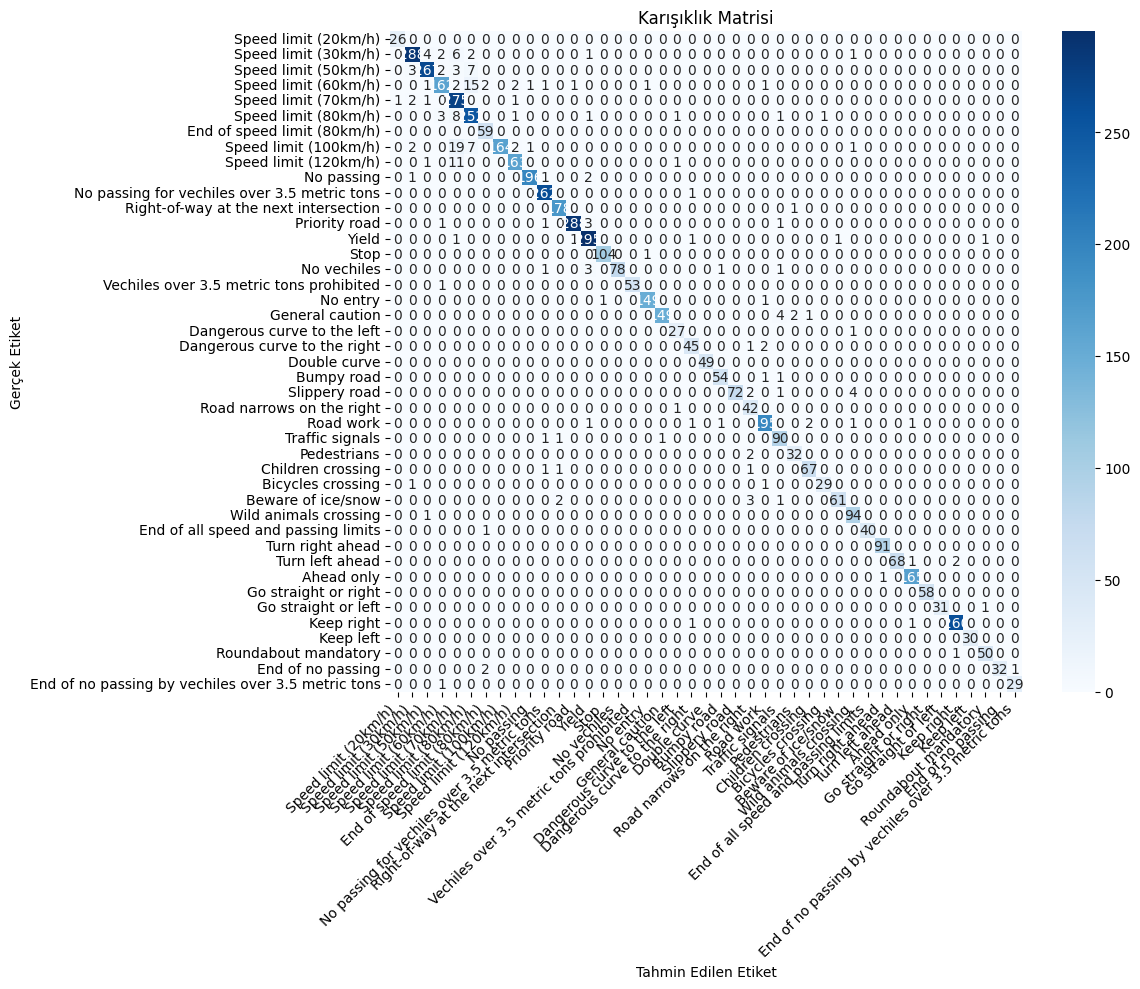

Sınıf Bazlı Doğruluk Raporu:

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.96      1.00      0.98        26
                              Speed limit (30km/h)       0.97      0.95      0.96       304
                              Speed limit (50km/h)       0.97      0.95      0.96       282
                              Speed limit (60km/h)       0.94      0.86      0.90       189
                              Speed limit (70km/h)       0.85      0.98      0.91       280
                              Speed limit (80km/h)       0.89      0.94      0.91       268
                       End of speed limit (80km/h)       0.92      1.00      0.96        59
                             Speed limit (100km/h)       1.00      0.84      0.91       196
                             Speed limit (120km/h)       0.96      0.93      0.94       176
                                        No passin

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sınıf isimlerini liste olarak alalım
class_names = class_names['SignName'].values  # Sınıf isimlerini 'SignName' sütunundan alıyoruz

# Karışıklık matrisi oluşturma
conf_matrix = confusion_matrix(y_test, y_pred)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(12, 10))  # Boyutu biraz büyüttük
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karışıklık Matrisi')
plt.xticks(rotation=45, ha="right")  # Etiketlerin daha kolay okunması için döndürme
plt.yticks(rotation=0)
plt.tight_layout()  # Grafiklerin daha iyi oturmasını sağlar
plt.show()

# Sınıf bazlı doğruluk metrikleri
print("Sınıf Bazlı Doğruluk Raporu:\n")
print(classification_report(y_test, y_pred, target_names=class_names))



* Görüntüleri düzleştirme
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
burada verıyı degıstıyoruım orjınal halıne getır ve cıktıyı goster de


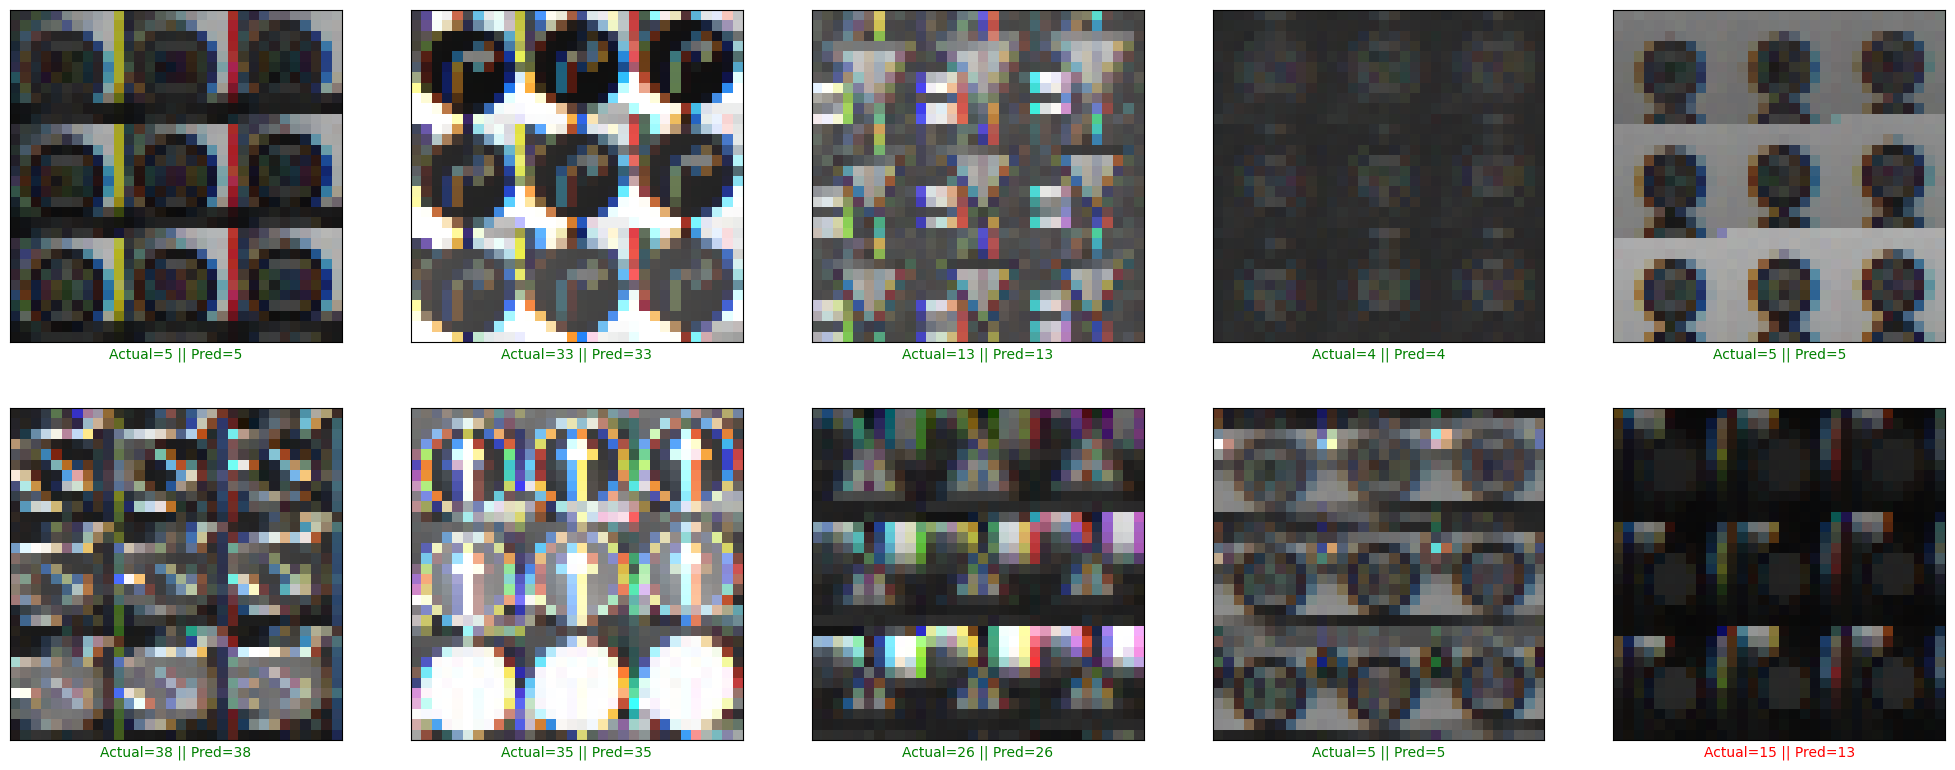

In [9]:
# 25 örneği görselleştirme
plt.figure(figsize=(25, 25))

start_index = 0
for i in range(10):  # 10 örnek göstermek için aralığı 25'e çıkardık
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    prediction = y_pred[start_index + i]  # Tahmin edilen etiket
    actual = y_test[start_index + i]      # Gerçek etiket

    # Renkleri belirle
    col = 'g' if prediction == actual else 'r'

    # Gerçek ve tahmin edilen etiketleri doğrudan görüntü üzerinde göster
    plt.xlabel(f'Actual={actual} || Pred={prediction}', color=col)

    # Görüntüleri yeniden şekillendirerek göster
    img = X_test[start_index + i].reshape(32, 32, 3)  # RGB görüntü olduğu varsayılıyor
    plt.imshow(img)

plt.show()


**Hiperparametre Optimizasyonu**

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# StandardScaler ve MLPClassifier'ı bir pipeline içinde kullanma
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Veriyi standartlaştırma
    ('mlp', MLPClassifier())        # MLP sınıflandırıcısı
])

# Hiperparametre ızgarasını tanımlama
param_grid = {
    'mlp__hidden_layer_sizes': [(64,), (128, 64), (256, 128, 64)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__max_iter': [200, 500]
}

# GridSearchCV ile parametre araması yapma
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_flattened, y_train)

# En iyi parametreler
print(f"En İyi Parametreler: {grid_search.best_params_}")

# En iyi model ile doğruluğu hesaplama
best_mlp_model = grid_search.best_estimator_
y_pred = best_mlp_model.predict(X_test_flattened)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Doğruluğu (En İyi Model): {accuracy:.4f}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
En İyi Parametreler: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (256, 128, 64), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 500}
Test Doğruluğu (En İyi Model): 0.9604


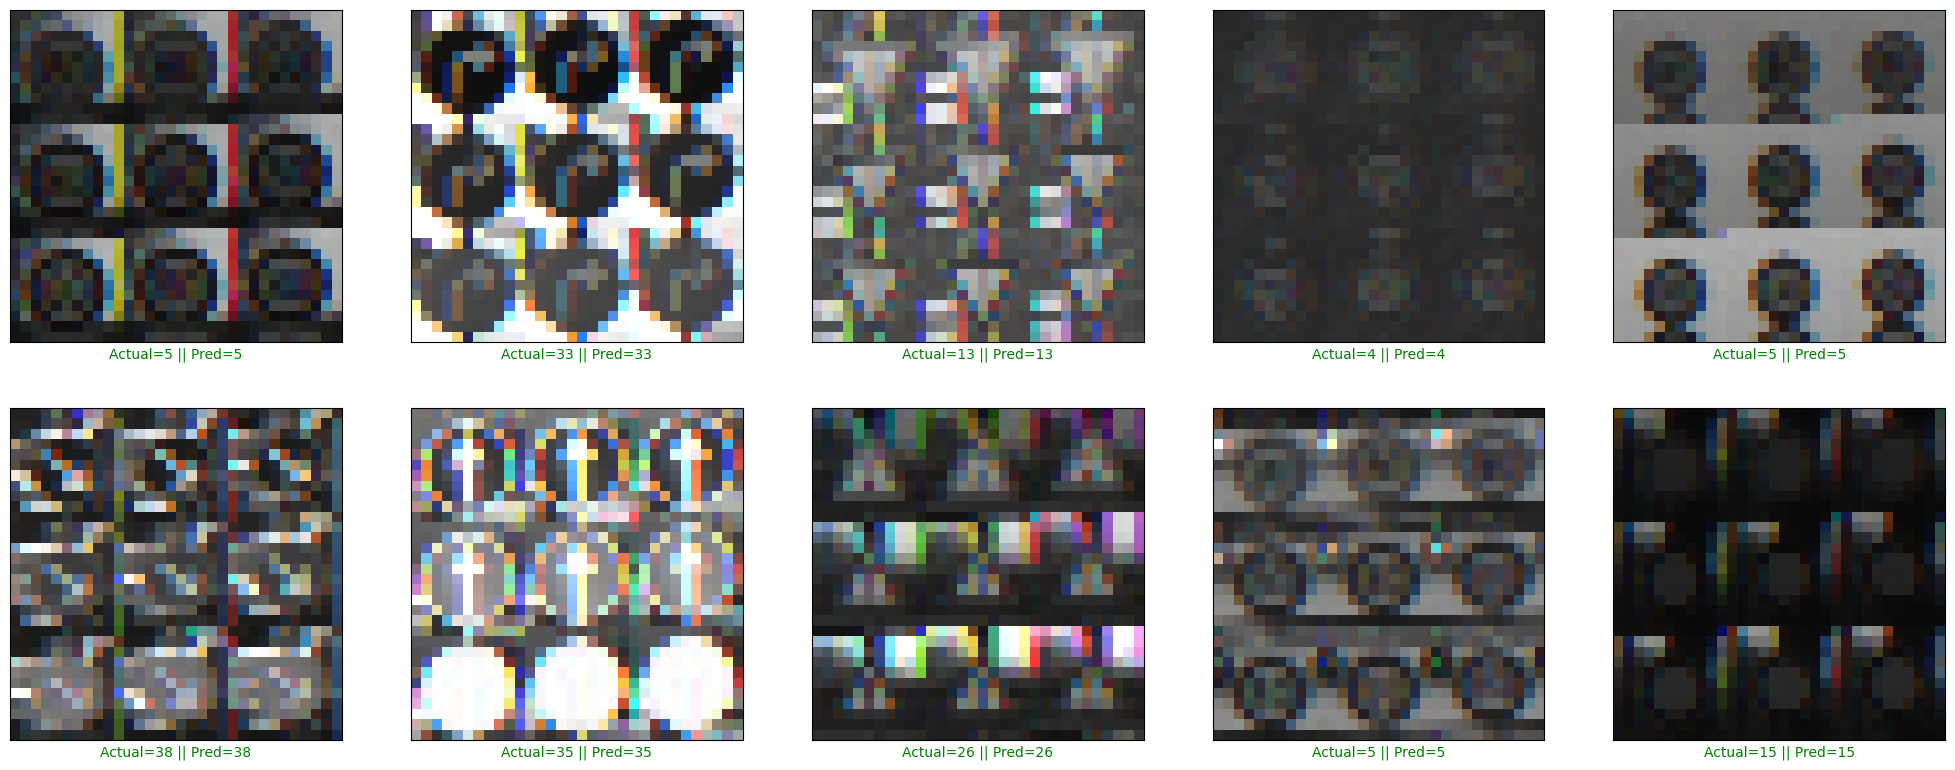

In [11]:
# 25 örneği görselleştirme
plt.figure(figsize=(25, 25))

start_index = 0
for i in range(10):  # 10 örnek göstermek için aralığı 25'e çıkardık
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    prediction = y_pred[start_index + i]  # Tahmin edilen etiket
    actual = y_test[start_index + i]      # Gerçek etiket

    # Renkleri belirle
    col = 'g' if prediction == actual else 'r'

    # Gerçek ve tahmin edilen etiketleri doğrudan görüntü üzerinde göster
    plt.xlabel(f'Actual={actual} || Pred={prediction}', color=col)

    # Görüntüleri yeniden şekillendirerek göster
    img = X_test[start_index + i].reshape(32, 32, 3)  # RGB görüntü olduğu varsayılıyor
    plt.imshow(img)

plt.show()


class_names zaten bir liste veya numpy array olabilir.
Değerler: ['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vechiles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vechiles' 'Vechiles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road'
 'Slippery road' 'Road narrows on the right' 'Road work' 'Traffic signals'
 'Pedestrians' 'Children crossing' 'Bicycles crossing'
 'Beware of ice/snow' 'Wild animals crossing'
 'End of all speed and passing limits' 'Turn right ahead'
 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' 'Keep right' 'Keep left' 'Roundabout mandatory'
 'End of no passing' 'End of no passing by v

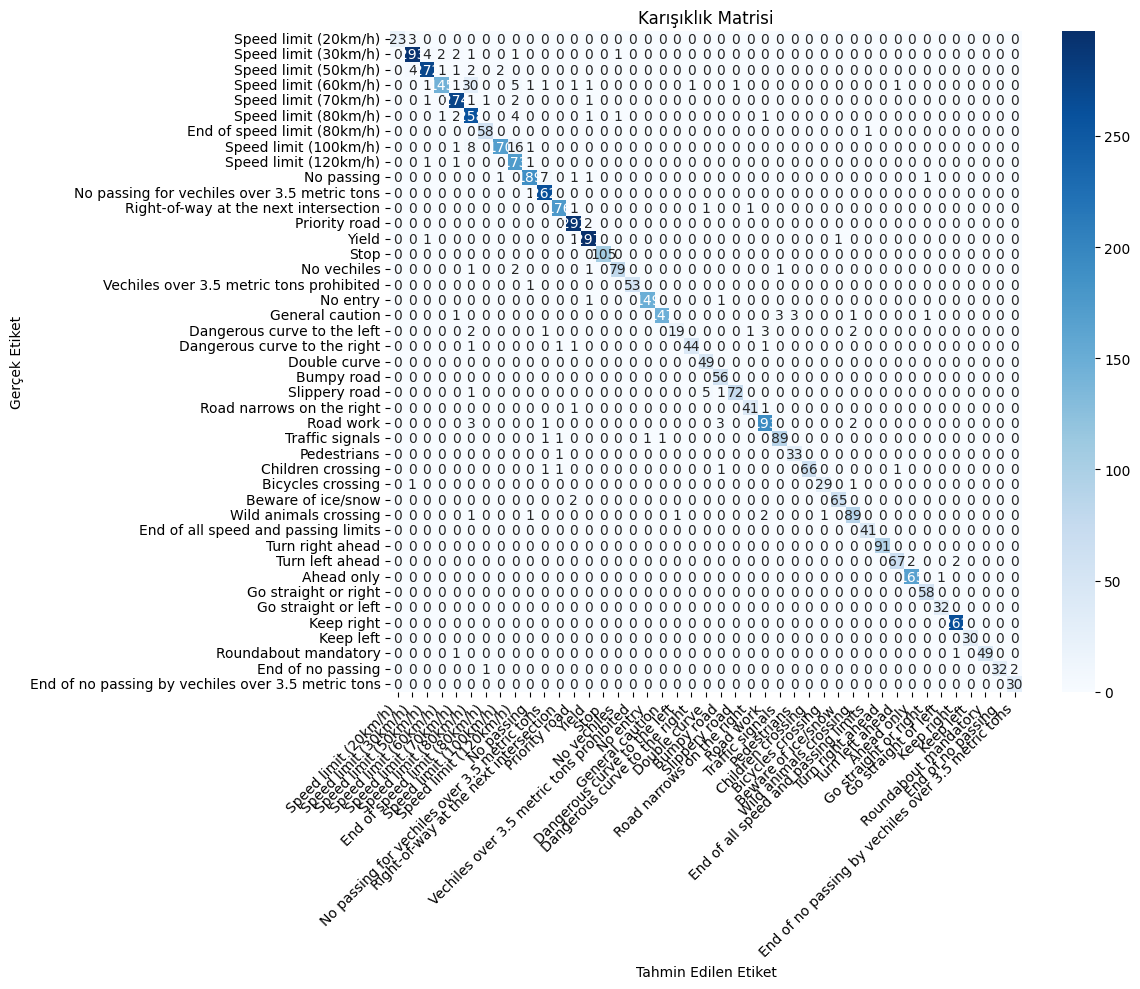

Sınıf Bazlı Doğruluk Raporu:

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      0.88      0.94        26
                              Speed limit (30km/h)       0.97      0.96      0.97       304
                              Speed limit (50km/h)       0.97      0.96      0.97       282
                              Speed limit (60km/h)       0.97      0.77      0.86       189
                              Speed limit (70km/h)       0.96      0.98      0.97       280
                              Speed limit (80km/h)       0.83      0.96      0.89       268
                       End of speed limit (80km/h)       0.97      0.98      0.97        59
                             Speed limit (100km/h)       0.98      0.87      0.92       196
                             Speed limit (120km/h)       0.85      0.98      0.91       176
                                        No passin

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Eğer class_names bir DataFrame ise ve 'SignName' sütununu içeriyorsa:
if isinstance(class_names, pd.DataFrame) and 'SignName' in class_names.columns:
    class_names = class_names['SignName'].values  # Pandas serisini numpy array'e çevir
else:
    # Eğer class_names direkt bir liste veya numpy array ise:
    print("class_names zaten bir liste veya numpy array olabilir.")
    print("Değerler:", class_names)


# Karışıklık matrisi oluşturma
conf_matrix = confusion_matrix(y_test, y_pred)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(12, 10))  # Boyutu biraz büyüttük
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karışıklık Matrisi')
plt.xticks(rotation=45, ha="right")  # Etiketlerin daha kolay okunması için döndürme
plt.yticks(rotation=0)
plt.tight_layout()  # Grafiklerin daha iyi oturmasını sağlar
plt.show()

# Sınıf bazlı doğruluk metrikleri
print("Sınıf Bazlı Doğruluk Raporu:\n")
print(classification_report(y_test, y_pred, target_names=class_names))


# **RFB**

In [18]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Layer
import tensorflow as tf  # TensorFlow'u içeri aktarın
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# RBF katmanı için özel bir sınıf oluşturma
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = tf.constant(gamma)  # K.constant yerine tf.constant kullanın

    def build(self, input_shape):
        # Merkezleri (center) giriş boyutuna göre başlatma
        self.centers = self.add_weight(
            name='centers', shape=(self.units, input_shape[-1]),
            initializer='uniform', trainable=True
        )
        # RBF katmanını oluşturma
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Euclidean uzaklığı hesaplama
        diff = tf.expand_dims(inputs, axis=1) - self.centers
        l2 = tf.reduce_sum(tf.square(diff), axis=2)
        return tf.exp(-self.gamma * l2)

# Verileri standartlaştırma
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Modeli tanımlama
model = Sequential()
model.add(RBFLayer(units=10, gamma=0.5, input_shape=(X_train_scaled.shape[1],)))  # RBF katmanı
model.add(Dense(43, activation='softmax'))  # Çıktı katmanı (sınıf sayısına göre düzenlenmeli)

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Test doğruluğunu hesaplama
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Doğruluğu: {accuracy:.4f}")


<ipython-input-18-5158071eabea>:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


Epoch 1/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.0528 - loss: 3.7168 - val_accuracy: 0.0525 - val_loss: 3.6218
Epoch 2/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0573 - loss: 3.5933 - val_accuracy: 0.0525 - val_loss: 3.5601
Epoch 3/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0568 - loss: 3.5343 - val_accuracy: 0.0525 - val_loss: 3.5343
Epoch 4/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0571 - loss: 3.5155 - val_accuracy: 0.0525 - val_loss: 3.5238
Epoch 5/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0588 - loss: 3.4999 - val_accuracy: 0.0525 - val_loss: 3.5198
Epoch 6/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0594 - loss: 3.4989 - val_accuracy: 0.0525 - val_loss: 3.5185
Epoch 7/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0561 - loss: 3.4941 - val_accuracy: 0.0525 - val_loss: 3.5181
Epoch 8/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0568 - loss: 3.4908 - val_accuracy: 0.

class_names zaten bir liste veya numpy array olabilir.
Değerler: ['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vechiles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vechiles' 'Vechiles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road'
 'Slippery road' 'Road narrows on the right' 'Road work' 'Traffic signals'
 'Pedestrians' 'Children crossing' 'Bicycles crossing'
 'Beware of ice/snow' 'Wild animals crossing'
 'End of all speed and passing limits' 'Turn right ahead'
 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' 'Keep right' 'Keep left' 'Roundabout mandatory'
 'End of no passing' 'End of no passing by v

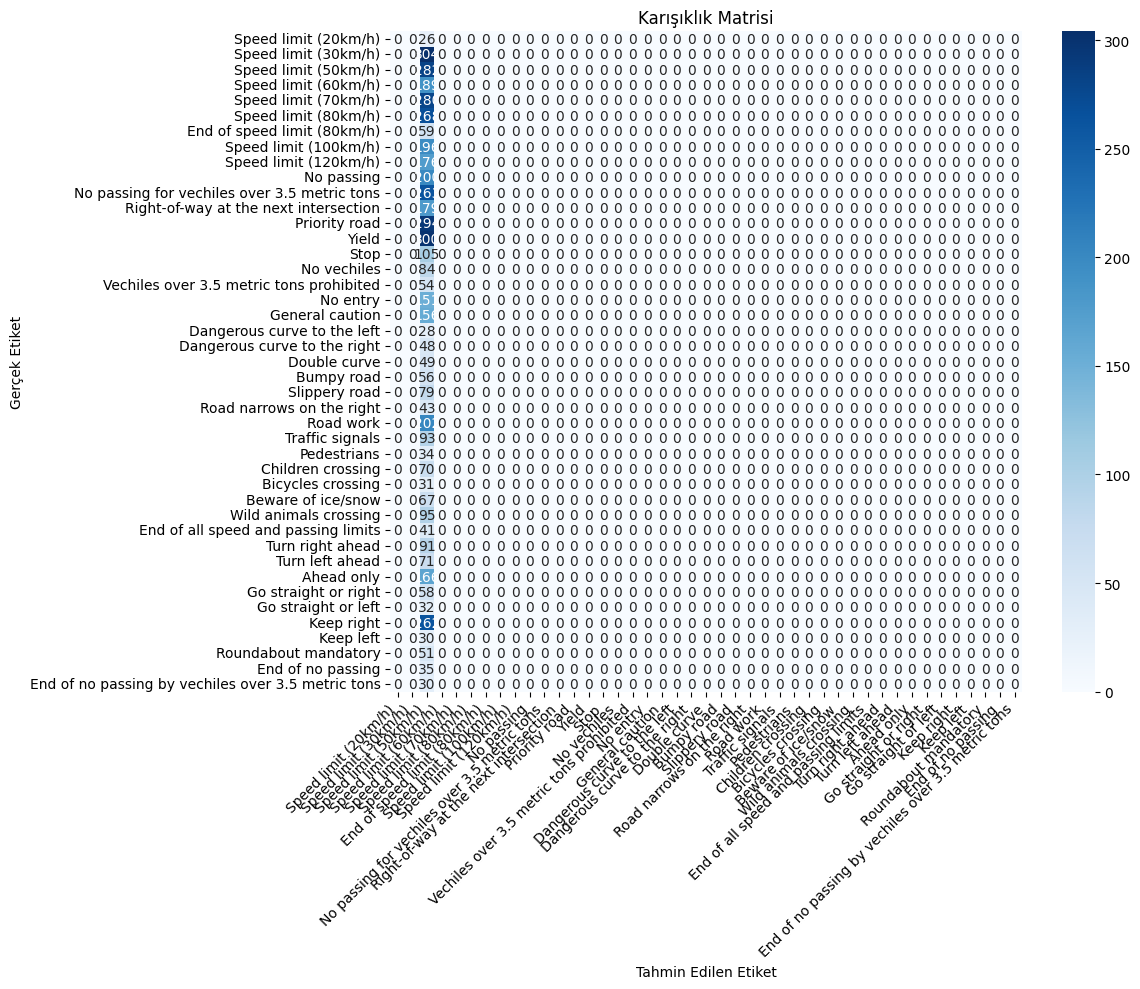

Sınıf Bazlı Doğruluk Raporu:

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.00      0.00      0.00        26
                              Speed limit (30km/h)       0.00      0.00      0.00       304
                              Speed limit (50km/h)       0.05      1.00      0.10       282
                              Speed limit (60km/h)       0.00      0.00      0.00       189
                              Speed limit (70km/h)       0.00      0.00      0.00       280
                              Speed limit (80km/h)       0.00      0.00      0.00       268
                       End of speed limit (80km/h)       0.00      0.00      0.00        59
                             Speed limit (100km/h)       0.00      0.00      0.00       196
                             Speed limit (120km/h)       0.00      0.00      0.00       176
                                        No passin

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Eğer class_names bir DataFrame ise ve 'SignName' sütununu içeriyorsa:
if isinstance(class_names, pd.DataFrame) and 'SignName' in class_names.columns:
    class_names = class_names['SignName'].values  # Pandas serisini numpy array'e çevir
else:
    # Eğer class_names direkt bir liste veya numpy array ise:
    print("class_names zaten bir liste veya numpy array olabilir.")
    print("Değerler:", class_names)

# Karışıklık matrisi oluşturma
conf_matrix = confusion_matrix(y_test, y_pred)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(12, 10))  # Boyutu biraz büyüttük
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karışıklık Matrisi')
plt.xticks(rotation=45, ha="right")  # Etiketlerin daha kolay okunması için döndürme
plt.yticks(rotation=0)
plt.tight_layout()  # Grafiklerin daha iyi oturmasını sağlar
plt.show()

# Sınıf bazlı doğruluk metrikleri
print("Sınıf Bazlı Doğruluk Raporu:\n")
print(classification_report(y_test, y_pred, target_names=class_names))


In [20]:
pip install scikeras


In [21]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np
from keras.layers import Dense, Layer
from keras.models import Sequential
from keras.optimizers import Adam

# RBF katmanı için özel bir sınıf
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = tf.constant(gamma)

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, input_shape[-1]),
            initializer='uniform',
            trainable=True
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, axis=1) - self.centers
        l2 = tf.reduce_sum(tf.square(diff), axis=2)
        return tf.exp(-self.gamma * l2)

# Model oluşturma fonksiyonu
def create_model(units=10, gamma=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(RBFLayer(units=units, gamma=gamma, input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(y_train.max() + 1, activation='softmax'))  # Çıkış katmanı (sınıf sayısına göre dinamik)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Verileri standartlaştırma
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# KerasClassifier ile sarmalama
model = KerasClassifier(model=create_model, verbose=0)

# Hiperparametrelerin tanımlanması
param_grid = {
    'model__units': [5, 10, 20],
    'model__gamma': [0.1, 0.5, 1.0],
    'model__learning_rate': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20]
}

# GridSearchCV ile optimizasyon
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train_scaled, y_train)

# En iyi parametreler ve doğruluk
print(f"En İyi Parametreler: {grid_result.best_params_}")
print(f"En İyi Doğruluk: {grid_result.best_score_:.4f}")

# Test setiyle performans değerlendirme
best_model = grid_result.best_estimator_

# Tahminleri sınıf etiketlerine dönüştür
y_pred = best_model.model_.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=-1)  # Olasılıkları sınıf etiketlerine dönüştür

# Doğruluğu hesapla
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Doğruluğu: {accuracy:.4f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=  13.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=  13.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=  12.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=  12.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=  13.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=  12.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=  12.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=  12.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=  13.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=  12.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=  12.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=  12.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=  12.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=  12.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=  12.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=  12.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=  12.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=  13.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=  13.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=  13.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=  13.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=  13.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=  12.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=  12.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=  12.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=  12.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=  12.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=  22.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=  23.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=  23.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=  23.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=  23.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=  23.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=  23.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=  23.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=  23.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=  24.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=  23.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=  23.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=  23.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=  22.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=  23.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=  23.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=  23.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=  23.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=  23.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=  23.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=  22.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=  23.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=  23.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=  22.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=  23.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=  23.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=  23.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=  22.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=  22.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=  22.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=  23.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=  22.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=  23.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=  24.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=  23.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=  23.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=  23.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=  23.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=  23.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=  23.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=  23.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=  23.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=16, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=  23.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=   9.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=   8.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=   8.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=   7.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=   7.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=   7.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=   9.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=   8.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=   8.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=   8.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=   8.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=   7.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=   8.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=   8.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=   7.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=   7.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=   7.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=   8.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=  15.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=  14.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=  13.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=  13.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=  14.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=  13.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=  13.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=  14.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=  14.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=  13.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=  13.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=  15.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=  14.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=  14.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=32, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=  14.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=   6.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=   6.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=   7.1s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=   5.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=   5.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=   5.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=   5.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=   5.3s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=   7.2s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=   5.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=   5.6s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=   5.5s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=10, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=   5.4s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=   8.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=   8.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=5; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=10; total time=   8.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.001, model__units=20; total time=   9.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=5; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=10; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.1, model__learning_rate=0.01, model__units=20; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=5; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=   8.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=10; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.001, model__units=20; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=5; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=10; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=0.5, model__learning_rate=0.01, model__units=20; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=5; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=10; total time=   8.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.001, model__units=20; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=   9.0s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=5; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=   8.8s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=10; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=   8.7s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=  10.9s


<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


[CV] END batch_size=64, epochs=20, model__gamma=1.0, model__learning_rate=0.01, model__units=20; total time=   9.0s


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
<ipython-input-21-7421462f88f7>:14: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RBFLayer, self).__init__(**kwargs)


En İyi Parametreler: {'batch_size': 16, 'epochs': 20, 'model__gamma': 0.1, 'model__learning_rate': 0.001, 'model__units': 10}
En İyi Doğruluk: 0.0573
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Doğruluğu: 0.0531


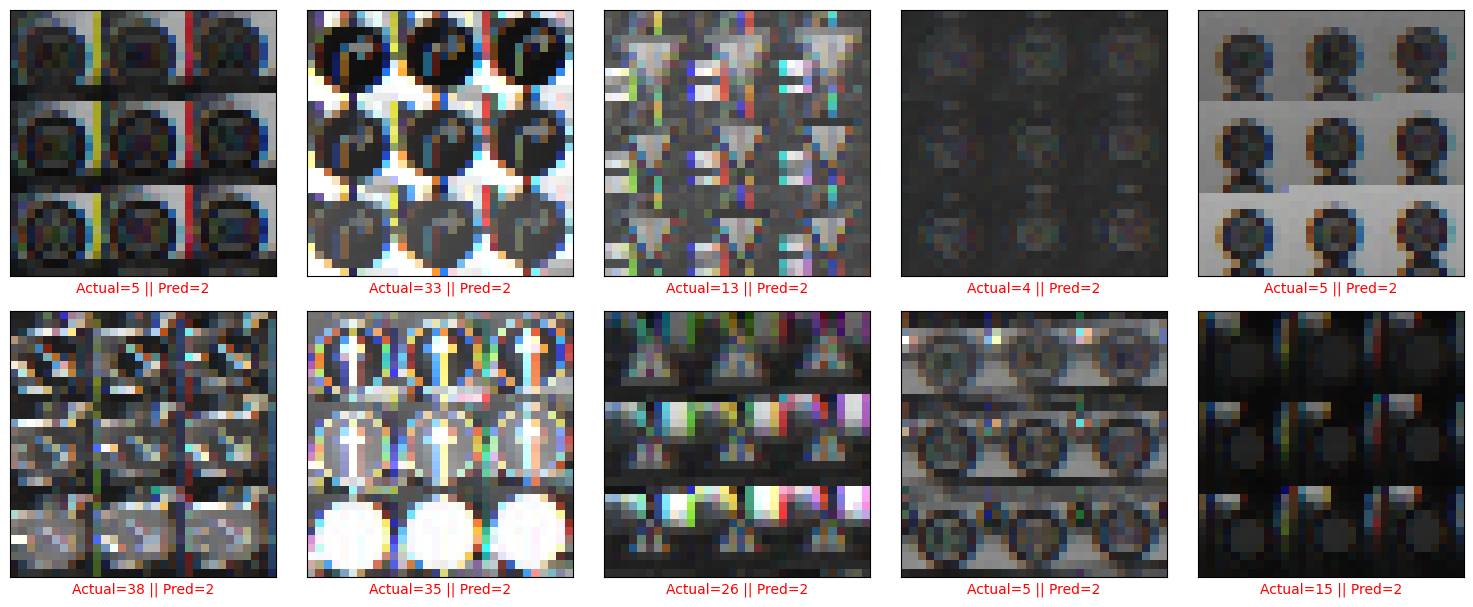

In [22]:
# 10 örneği görselleştirme
plt.figure(figsize=(15, 15))

start_index = 0
for i in range(10):  # 10 örnek göstermek için döngüyü 10'da sınırlandırdık
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Tahmin edilen ve gerçek etiketleri skalar değerlere dönüştürme
    prediction = np.argmax(y_pred[start_index + i])  # En yüksek olasılığa sahip sınıf
    actual = y_test[start_index + i]  # Gerçek etiket

    # Renkleri belirle
    col = 'g' if prediction == actual else 'r'

    # Gerçek ve tahmin edilen etiketleri doğrudan görüntü üzerinde göster
    plt.xlabel(f'Actual={actual} || Pred={prediction}', color=col)

    # Görüntüleri yeniden şekillendirerek göster
    img = X_test[start_index + i].reshape(32, 32, 3)  # RGB görüntü olduğu varsayılıyor
    plt.imshow(img)

plt.tight_layout()
plt.show()


class_names zaten bir liste veya numpy array olabilir.
Değerler: ['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vechiles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vechiles' 'Vechiles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road'
 'Slippery road' 'Road narrows on the right' 'Road work' 'Traffic signals'
 'Pedestrians' 'Children crossing' 'Bicycles crossing'
 'Beware of ice/snow' 'Wild animals crossing'
 'End of all speed and passing limits' 'Turn right ahead'
 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' 'Keep right' 'Keep left' 'Roundabout mandatory'
 'End of no passing' 'End of no passing by v

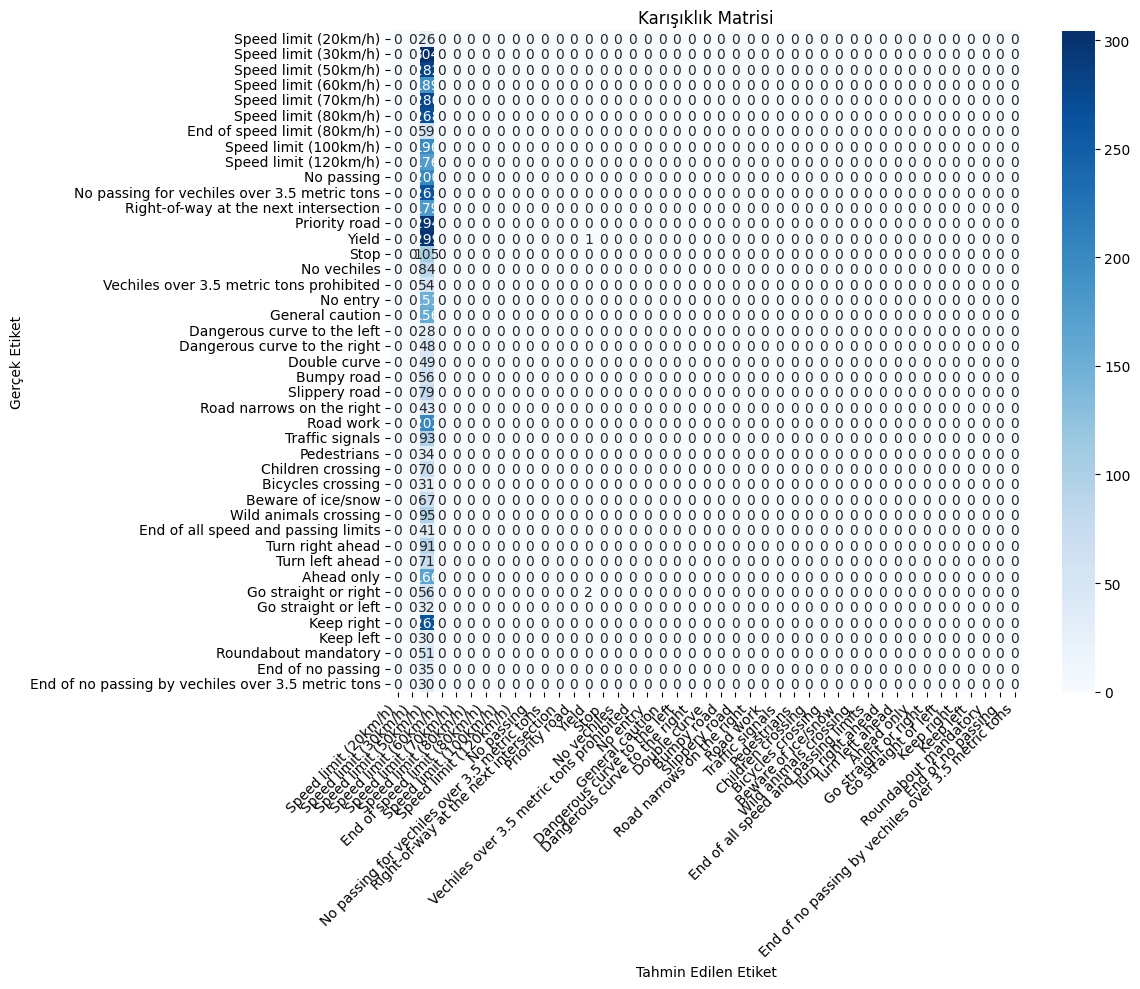

Sınıf Bazlı Doğruluk Raporu:

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.00      0.00      0.00        26
                              Speed limit (30km/h)       0.00      0.00      0.00       304
                              Speed limit (50km/h)       0.05      1.00      0.10       282
                              Speed limit (60km/h)       0.00      0.00      0.00       189
                              Speed limit (70km/h)       0.00      0.00      0.00       280
                              Speed limit (80km/h)       0.00      0.00      0.00       268
                       End of speed limit (80km/h)       0.00      0.00      0.00        59
                             Speed limit (100km/h)       0.00      0.00      0.00       196
                             Speed limit (120km/h)       0.00      0.00      0.00       176
                                        No passin

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Eğer class_names bir DataFrame ise ve 'SignName' sütununu içeriyorsa:
if isinstance(class_names, pd.DataFrame) and 'SignName' in class_names.columns:
    class_names = class_names['SignName'].values  # Pandas serisini numpy array'e çevir
else:
    # Eğer class_names direkt bir liste veya numpy array ise:
    print("class_names zaten bir liste veya numpy array olabilir.")
    print("Değerler:", class_names)

# y_pred'i sınıf etiketlerine dönüştürme
y_pred_classes = np.argmax(y_pred, axis=1)  # En yüksek olasılığa sahip sınıfı seçiyoruz

# Karışıklık matrisi oluşturma
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(12, 10))  # Boyutu biraz büyüttük
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karışıklık Matrisi')
plt.xticks(rotation=45, ha="right")  # Etiketlerin daha kolay okunması için döndürme
plt.yticks(rotation=0)
plt.tight_layout()  # Grafiklerin daha iyi oturmasını sağlar
plt.show()

# Sınıf bazlı doğruluk metrikleri
print("Sınıf Bazlı Doğruluk Raporu:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))
